<font color='tomato'><font color="#CC3D3D"><p>
# Conv1D based Model

<img src='http://drive.google.com/uc?export=view&id=1mJrrYAhszKsv7WZU7yzVWFMuU-Hl5IhK' width=700 height=500/>

In [2]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
print(tf.__version__)

# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(seed, reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(seed)
    random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print(f"Random seeds reset: {seed}")  # optional
   
reset_seeds(1)

2.3.1
Random seeds reset: 1234


### Read Data

In [4]:
df_train = pd.read_csv(r"C:/Users/MSI/Desktop/Kaggle/train_transactions.csv", encoding='cp949')
df_test = pd.read_csv(r"C:/Users/MSI/Desktop/Kaggle/test_transactions.csv", encoding='cp949')
y_train = pd.read_csv(r"C:/Users/MSI/Desktop/Kaggle/y_train.csv").gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Transform Data

In [5]:
max_features = 100000
max_len = 100
emb_dim = 128

##### low level: goods_id

In [6]:
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space
df_train.goods_id = df_train.goods_id.apply(lambda x: str(x))
df_test.goods_id = df_test.goods_id.apply(lambda x: str(x))
X_train = df_train.groupby('cust_id')['goods_id'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['goods_id'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_low = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_low = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_low.shape, X_test_low.shape

((3500, 100), (2482, 100))

##### middle level: gds_grp_nm

In [5]:
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//10)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//10)[0] for i in x]).values

# Pads sequences to the same length
X_train_mid = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_mid = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_mid.shape, X_test_mid.shape

((3500, 100), (2482, 100))

##### high level: gds_grp_mclas_nm

In [6]:
# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_high = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_high.shape, X_test_high.shape

((3500, 100), (2482, 100))

##### store

In [7]:
# Converts a "store_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['store_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['store_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_str = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_str = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_str.shape, X_test_str.shape

((3500, 100), (2482, 100))

##### weekday

In [8]:
# Converts a "tran_date" to a sequence of indexes in a fixed-size hashing space
df_train.tran_date = pd.to_datetime(df_train.tran_date).dt.weekday
df_test.tran_date = pd.to_datetime(df_test.tran_date).dt.weekday
X_train = df_train.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values
X_test = df_test.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values

# Pads sequences to the same length
X_train_day = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_day = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_day.shape, X_test_day.shape

((3500, 100), (2482, 100))

### Build Models

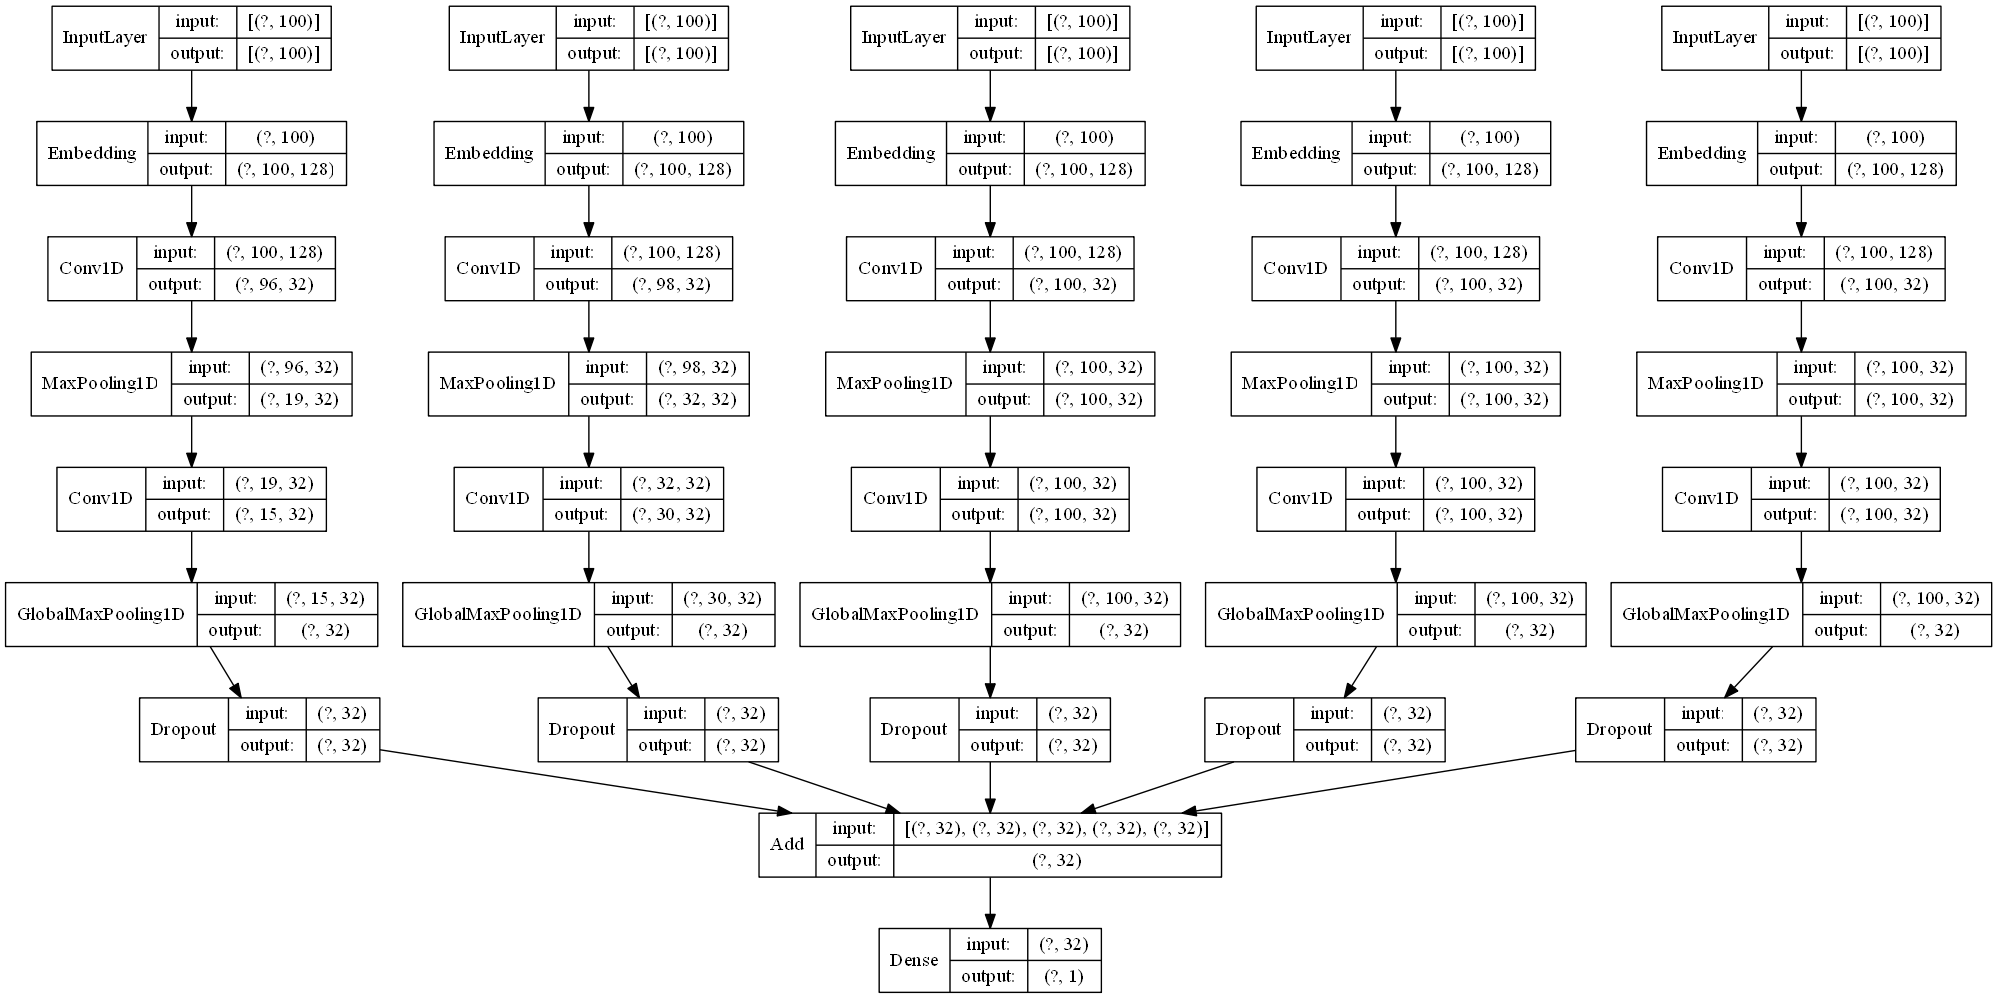

In [9]:
# Define the Model & its Architecture

in_low = keras.Input(shape=(max_len,), dtype='int32', name='low')
x = keras.layers.Embedding(max_features, emb_dim)(in_low)
x = keras.layers.Conv1D(32, 5, activation='elu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(32, 5, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_low = keras.layers.Dropout(0.5)(x)

in_mid = keras.Input(shape=(max_len,), dtype='int32', name='mid')
x = keras.layers.Embedding(max_features//10, emb_dim)(in_mid)
x = keras.layers.Conv1D(32, 3, activation='elu')(x)
x = keras.layers.MaxPooling1D(3)(x)
x = keras.layers.Conv1D(32, 3, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_mid = keras.layers.Dropout(0.5)(x)

in_high = keras.Input(shape=(max_len,), dtype='int32', name='high')
x = keras.layers.Embedding(max_features//100, emb_dim)(in_high)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.MaxPooling1D(1)(x)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_high = keras.layers.Dropout(0.5)(x)

in_str = keras.Input(shape=(max_len,), dtype='int32', name='store')
x = keras.layers.Embedding(max_features//100, emb_dim)(in_str)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.MaxPooling1D(1)(x)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_str = keras.layers.Dropout(0.5)(x)

in_day = keras.Input(shape=(max_len,), dtype='int32', name='day')
x = keras.layers.Embedding(7, emb_dim)(in_day)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.MaxPooling1D(1)(x)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_day = keras.layers.Dropout(0.5)(x)

x = keras.layers.add([out_low, out_mid, out_high, out_str, out_day], name='my_layer')
out = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model([in_low, in_mid, in_high, in_str, in_day], out)
Image(keras.utils.model_to_dot(model,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

Epoch 1/50
44/44 [==============================] - 6s 144ms/step - loss: 0.6570 - roc_auc: 0.5649 - val_loss: 0.6443 - val_roc_auc: 0.6360
Epoch 2/50
44/44 [==============================] - 6s 143ms/step - loss: 0.6367 - roc_auc: 0.6372 - val_loss: 0.6362 - val_roc_auc: 0.6533
Epoch 3/50
44/44 [==============================] - 6s 140ms/step - loss: 0.6244 - roc_auc: 0.6691 - val_loss: 0.6308 - val_roc_auc: 0.6646
Epoch 4/50
44/44 [==============================] - 6s 138ms/step - loss: 0.6210 - roc_auc: 0.6730 - val_loss: 0.6256 - val_roc_auc: 0.6737
Epoch 5/50
44/44 [==============================] - 6s 138ms/step - loss: 0.6156 - roc_auc: 0.6820 - val_loss: 0.6205 - val_roc_auc: 0.6830
Epoch 6/50
44/44 [==============================] - 6s 144ms/step - loss: 0.6052 - roc_auc: 0.7047 - val_loss: 0.6150 - val_roc_auc: 0.6923
Epoch 7/50
44/44 [==============================] - 6s 144ms/step - loss: 0.5969 - roc_auc: 0.7183 - val_loss: 0.6103 - val_roc_auc: 0.7018
Epoch 8/50
44/44 [==

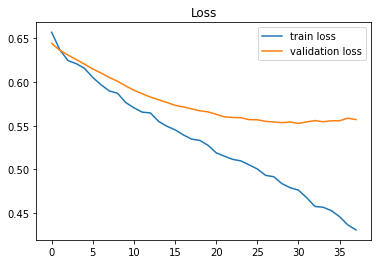

In [10]:
# Choose the Optimizer and the Cost function
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(name='roc_auc')])

# Train the Model
history = model.fit([X_train_low, X_train_mid, X_train_high, X_train_str, X_train_day], y_train, 
                    epochs=50, batch_size=64,
                    validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=7)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Make Submissions

In [11]:
pred = model.predict([X_test_low, X_test_mid, X_test_high, X_test_str, X_test_day]).flatten()
t = pd.Timestamp.now()
fname = f"Conv1D_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'Conv1D_submission_12121658.csv' is ready to submit.


<font color='tomato'><font color="#CC3D3D"><p>
# End